In [2]:
# Imports
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import seaborn as sn
import dask
from dask.distributed import Client
import dask.bag as db

In [3]:
dtypes = {'buildingblock1_smiles': np.int16, 'buildingblock2_smiles': np.int16, 'buildingblock3_smiles': np.int16,
          'binds_BRD4':np.byte, 'binds_HSA':np.byte, 'binds_sEH':np.byte}

directory = Path("../data/shrunken/")
train = pd.read_parquet(directory / "train.parquet")

In [4]:
BBs_dict_reverse_1 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_1.p', 'br'))
BBs_dict_reverse_2 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_2.p', 'br'))
BBs_dict_reverse_3 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_3.p', 'br'))

In [5]:
client = Client()

In [6]:
# Get 25 descriptors
desc_list = [desc_func for desc_name, desc_func in Descriptors._descList][:18]
desc_names = [desc_name for desc_name, desc_func in Descriptors._descList][:18]

def calculate_single_descriptor(mol, desc):
    return desc(mol)

# Create a function to calculate descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    desc = [calculate_single_descriptor(mol, desc) for desc in desc_list]
    return desc


In [80]:
# Create train dataset with 25% binds_BRD4 or binds_HSA or binds_sEH and 75% no binds
train_df = train[(train.binds_BRD4 == 1) | (train.binds_HSA == 1) | (train.binds_sEH == 1)].sample(n=1000)
train_df = pd.concat([train_df, train[(train.binds_BRD4 == 0) & (train.binds_HSA == 0) & (train.binds_sEH == 0)].sample(n=9000)])
train_df.reset_index(drop=True, inplace=True)

In [28]:
# Sample from the train dataset 10,000
train_df = train.sample(n=10000)

In [81]:
b = db.from_sequence(train_df.molecule_smiles)
descriptors = b.map(calculate_descriptors)

In [82]:
descriptors = descriptors.compute()

In [83]:
len(descriptors)

10000

In [84]:
# Create a dataframe
desc_df = pd.DataFrame(descriptors, columns=desc_names)

# Add the target columns
desc_df['binds_BRD4'] = train_df.binds_BRD4
desc_df['binds_HSA'] = train_df.binds_HSA
desc_df['binds_sEH'] = train_df.binds_sEH

In [85]:
print(f"Percentage of rows with at least one binding: {desc_df[(desc_df.binds_BRD4 == 1) | (desc_df.binds_HSA == 1) | (desc_df.binds_sEH == 1)].shape[0] / desc_df.shape[0] * 100:.2f}%")

Percentage of rows with at least one binding: 10.00%


In [86]:
# Number of rows with at least one binding
desc_df[(desc_df.binds_BRD4 == 1) | (desc_df.binds_HSA == 1) | (desc_df.binds_sEH == 1)].shape[0]

1000

In [87]:
# Replace NaN values with 0
desc_df.fillna(0, inplace=True)

# Replace inf values with 0
desc_df.replace([np.inf, -np.inf], 0, inplace=True)

In [89]:
# Train unsupervised model to cluster the data and colour the molecules based on what protein they bind to
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a KMeans model
kmeans = KMeans(n_clusters=4, random_state=42, verbose=1)
kmeans.fit(desc_df.iloc[:, :-3])

# Create a TSNE model
tsne = TSNE(n_components=2, random_state=42, verbose=1)
tsne_df = tsne.fit_transform(desc_df.iloc[:, :-3])

Initialization complete
Iteration 0, inertia 51182623.69326934.
Iteration 1, inertia 45331959.90792198.
Iteration 2, inertia 43094863.157312945.
Iteration 3, inertia 41662858.710186385.
Iteration 4, inertia 40716580.876689255.
Iteration 5, inertia 40073212.74140003.
Iteration 6, inertia 39642342.64478256.
Iteration 7, inertia 39285011.47053164.
Iteration 8, inertia 39031390.055262916.
Iteration 9, inertia 38831191.92100302.
Iteration 10, inertia 38665010.509855114.
Iteration 11, inertia 38533878.91137339.
Iteration 12, inertia 38436393.516246356.
Iteration 13, inertia 38379410.575878404.
Iteration 14, inertia 38334043.81433408.
Iteration 15, inertia 38295008.252603084.
Iteration 16, inertia 38266644.35063208.
Iteration 17, inertia 38247806.53619983.
Iteration 18, inertia 38238165.96709191.
Iteration 19, inertia 38230741.6316866.
Iteration 20, inertia 38223571.1297099.
Iteration 21, inertia 38216877.028122164.
Iteration 22, inertia 38211717.91185062.
Iteration 23, inertia 38207850.18910

/tmp/ipykernel_1133480/378597795.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = desc_df[['binds_BRD4', 'binds_HSA', 'binds_sEH']].apply(lambda x: x[0] + 2*x[1] + 3*x[2], axis=1).to_list()


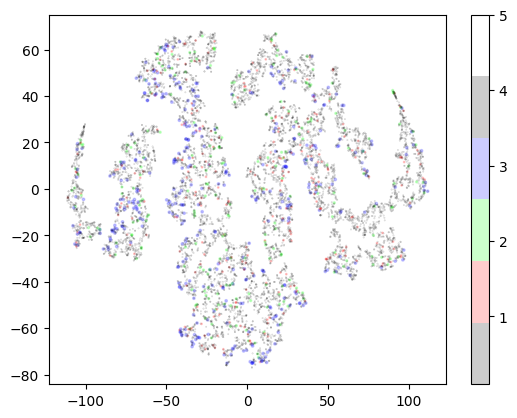

In [106]:
# Create a colormap where its see through for 0, red for 1, green for 2, blue for 3, black for 4 and white for 5
cmap = ListedColormap(['#000000', '#FF0000', '#00FF00', '#0000FF', '#000000', '#FFFFFF'])

# Plot with labels: Labels = (0,0,0) = 0, (1,0,0) = 1, (0,1,0) = 2, (0,0,1) = 3 
labels = desc_df[['binds_BRD4', 'binds_HSA', 'binds_sEH']].apply(lambda x: x[0] + 2*x[1] + 3*x[2], axis=1).to_list() 
# If labels = 0, size is 0.1
labels = [0.1 if x == 0 else x for x in labels]

# Scatter with small dots, if labels are larger than 0, the dots will be bigger
plt.scatter(tsne_df[:, 0], tsne_df[:, 1], c=labels, cmap=cmap, s=labels, alpha=0.2)
plt.colorbar()
plt.show()